# Using VQE to Approximate the Lowest Eigenvalue of a Hermitian Matrix
*Written by. Leo Becker*

VQE can approximate the lowest eigenvalue of a Hermitian matrix. The output is an eigenvaluea $\lambda$ of a matrix $M$ is such a number that there is a non zero vector $|v\rangle$ for witch

$$ M|v\rangle=\lambda|v\rangle$$

\[1\],and our input is a Hermitian matrix meaning that

$$ M=M^*$$

, where $^*$ denotes the conjugate transpose \[2\].

The most common usecase I see for the algorithm to calculate the ground state energy of a molecule. This work because a hamiltoanian of a molecule is a Hermitian matrix and the ground state energy levelt is its lowest eigenvalue \[8\].

The eigenvalue of a Hermitian matrix can also be interesting on other cases. My goal with this essay is to explain the algorithm in isolation. I will be using matrices to represent quantum gates and vectors for quantum states \[3\]. For a vector I will be using the notation $|v\rangle$ and for its transpose $\langle v|$.

First I will explain a bit about something called expectation value and some properties it has. Then there will be an example of showing how to run the algorithm on a $2\times 2$ to explain the algorithm. After that there will be a $4\times 4$ matrix to show how the algorithm scales for $2^n+2^b$ matrices. In the end will be a tric how to solve for $n\times n$ Hermitian matrices. 

Now I will introduce what in my opinion is the star of the show. I will be using $|\psi\rangle$ for a quantum state and $M$ as the Hermitian matrix.

## $$\langle\psi|M|\psi\rangle\equiv \langle M\rangle_\psi$$

This is often called the expectation value of $M$ in the state $\psi$ \[4\]. We will go through some properties it has. It is linear because

$$
\langle\psi|(aA+B)|\psi\rangle
=\langle\psi|aA|\psi\rangle+\langle\psi|B|\psi\rangle
=a\langle\psi|A|\psi\rangle+\langle\psi|B|\psi\rangle
$$

where $A,B \in \mathbb C^{n\times n}$, $n\in \mathbb N$ and $a \in \mathbb C$ . Hermitian matrices can be written as eigencompositions

$$M=\sum_i\lambda_i|\psi_i\rangle\langle\psi_i| $$

where the sum goes over all the eigenvalues $\lambda_i$ with theyr orthonormal unit eigenvectors $\psi_i$ \[2\]. With this information we get

$$
\langle\psi|M|\psi\rangle
=\langle\psi|(\sum_i\lambda_i|\psi_i\rangle\langle\psi_i|)|\psi\rangle
=\sum_i\lambda_i\langle\psi|\psi_i\rangle\langle\psi_i|\psi\rangle
=\sum_i\lambda_i|\langle\psi|\psi_i\rangle|^2
$$

. Now because $|\psi\rangle$ is a quantum state meaning that it is a unit vector and all $|\psi\rangle$ are also unitvectors and orthogonal. We always get

$$
\sum_i|\langle\psi|\psi_i\rangle|^2=1
$$

and $|\langle\psi|\psi_i\rangle|^2\leq 0$ meaning that we get a veighted sum of the eigenvalues an the minimum value of the expectation value is the lowest eigenvalue $\lambda_{min}$ and we get it when $\psi=\psi_{min}$

$$
\langle\psi|M|\psi\rangle
=\sum_i\lambda_i|\langle\psi_{min}|\psi_i\rangle|^2
=\lambda_{min}|\langle\psi_{min}|\psi_{min}\rangle|^2
=\lambda_{min}
$$

Now we know that for any quantum state $|\psi\rangle$

$$
\lambda_{min} \leq \langle\psi|M|\psi\rangle = \langle M\rangle_\psi
$$

We can calculate  $\langle M\rangle_\psi$ from measurements when we have enough repetitions, because the possibility to measure the quantum state as x is $|\langle\psi|x\rangle|^2$ \[6\]. So lets go through the algorithm.



## How Does it Work? $2\times 2$ Matrix

We need to solve 2 problems. How to make the quantum state $|\psi\rangle$ and how to read the expectation value? I will be using Qiskit to run my examples.

Because the matrix is $2\times2$ we need a state $|\psi\rangle$ that is a vector with 2 entities, meaning that we need only 1 qubit. We also want it to be able to be parametrized so that it can get low values from $\langle \psi|M|\psi \rangle$. To keep it simple we will have a sircuit that is often called anzats $U(\theta)$ that acts on the zero state $|0\rangle$. $U(\theta)$ can be mostly whatever as long as it has the right amount of qubits. Usually we want to have $|\psi\rangle$ so that it can get close to the eigenvector of the lowest eigenvalue. This is because $\langle \psi_{min}|M|\psi_{min}\rangle=\lambda_{min}$ \[1\]. I will use an anzats that was inspired by the anzats used in a Qiskit tutorial \[6\].


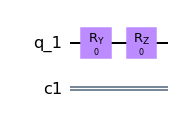

In [23]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def create_ansatz(params):
    qr = QuantumRegister(1, name="q_1")
    cr = ClassicalRegister(1, name='c1')
    qc = QuantumCircuit(qr, cr)
    qc.ry(params[0], qr[0])
    qc.rz(params[1], qr[0])
    return (qc, qr, cr)

create_ansatz([0,0])[0].draw(output='mpl')

As an example let us use the matrix

$$M=\begin{bmatrix}2&1\\1&2\end{bmatrix}$$

Now we have another problem. How do we get the M into the circuit. It would be nice to have a gate like M, but we can forget about that because $MM\neq I$ (does not cancel itself). So we need another way. Lucky for us we can use Pauli matrices and the identity matrix to create any $2\times 2$ Hermitian matrix \[3\]. The Pauli matrices as quantum gates are (we add I that does nothing here)

$$ X=\begin{bmatrix}0&1\\1&0\end{bmatrix} Y=\begin{bmatrix}0&-i\\i&0\end{bmatrix} Z=\begin{bmatrix}1&0\\0&-1\end{bmatrix} I=\begin{bmatrix}1&0\\0&1\end{bmatrix}$$

meaning that 

$$M=2I+X$$

\[4\]. Now we can calculate the expectation value with the formula

$$ \langle M\rangle_\psi = 2\langle I\rangle_\psi + \langle X\rangle_\psi$$



Our cost function will calculate the expectation value for every needed matrix and then add and multiply them to create the value. For this we need to be able to calculate the expectation values in the following way. For calculating $X$ we need the help of a Hadamar gate $H$ and that $X=HZH$.

\begin{equation}
\begin{split}
\langle X\rangle_{\psi}
&=\langle\psi|X|\psi\rangle
=\langle\psi|HZH|\psi\rangle\\
&=\langle H^*\psi|Z|H\psi\rangle
=\langle H\psi|Z|H\psi\rangle\\
&=\langle H\psi|0\rangle\langle0|H\psi\rangle-\langle H\psi|1\rangle\langle1|H\psi\rangle\\
&=|\langle H\psi|0\rangle|^2 - |\langle H\psi|1\rangle|^2 
\end{split}
\end{equation}

$$\langle I\rangle_{\psi} = \langle\psi|I|\psi\rangle=\langle\psi|0\rangle\langle0|\psi\rangle+\langle\psi|1\rangle\langle1|\psi\rangle=|\langle\psi|0\rangle|^2+|\langle\psi|1\rangle|^2$$

For $X$ We need to add $H$ first to get the desired state and for I we do not need to do anything. First we calculate the seperate expectation values.

The circuit for calculating the expectationvalue of X:


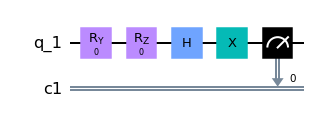

In [24]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
SHOTS = 10000

def expectation_value_X(params):
    qc, qr, cr = create_ansatz(params)
    qc.h(qr[0])
    qc.x(qr[0])
    qc.measure(qr, cr[0])
    transpiled = transpile(qc, backend)
    job = assemble(transpiled, shots=SHOTS)
    result = backend.run(job).result().get_counts(qc)
    return (result.get('0', 0) - result.get('1', 0)) / SHOTS
    
def expectation_value_I(params):
    qc, qr, cr = create_ansatz(params)
    qc.measure(qr, cr[0])
    transpiled = transpile(qc, backend)
    job = assemble(transpiled, shots=SHOTS)
    result = backend.run(job).result().get_counts(qc)
    return (result.get('0', 0) + result.get('1', 0)) / SHOTS

print("The circuit for calculating the expectationvalue of X:")
qc, qr, cr = create_ansatz([0,0])
qc.h(qr[0])
qc.x(qr[0])
qc.measure(qr, cr[0])
qc.draw(output='mpl')

Then we can make a cost fucntion that we can give to a classical program that optimizes the parameters so that the expectation value is minimized. Having a good starting quess for the parameter can help, but random works in this case. In the end we use the cost function to calculate the approximated smalles eigenvalue with the optimized parameters.

In [25]:
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np

def cost(params):
    expectation_X = expectation_value_X(params)
    expectation_I = expectation_value_I(params)
    return 2 * expectation_I + expectation_X

optimizer = COBYLA(maxiter=500, tol=0.0001)
params = np.random.rand(2)
result = optimizer.optimize(
    num_vars=2,
    objective_function=cost,
    initial_point=params
)


print(f'Parameter/s: {result[0]}')
print(f'Approximated lowest eigenvalue: {cost(result[0])}');

Parameter/s: [ 1.56648374 -0.0203255 ]
Approximated lowest eigenvalue: 1.0002


This is a pretty good result. The lowest eigenvalue is 1.


## $2^n\times 2^n$ Hermitian matrices

For $|\psi\rangle$ we only have to add more qubits. What changes is how we represent $M$. We can use parallel gates to create matrices with tensor products of the pauli matrices \[3\]. Because finding the representation as ternsor products of pauli matrices and calculating how to measure the expectationvalues afterwars, there are programs for doint that. As an examle 

$$
M=
\begin{bmatrix}
1&0&0&-i\\
0&1&i&0\\
0&-i&1&0\\
i&0&0&1
\end{bmatrix}
=
\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&1
\end{bmatrix}
+
\begin{bmatrix}
0&0&0&-i\\
0&0&i&0\\
0&-i&0&0\\
i&0&0&0
\end{bmatrix}
= I\otimes I + X\otimes Y
$$

Where $X\otimes Y$ on a quantum circuit looks like




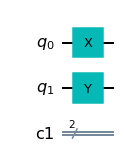

In [27]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

qr = QuantumRegister(2, name="q")
cr = ClassicalRegister(2, name='c1')
qc = QuantumCircuit(qr, cr)
qc.x(qr[0])
qc.y(qr[1])

qc.draw(output='mpl')

This shows one of the streghts of VQE it needs only $\log_2(n)$ qubits for a $\mathbb C^{n\times n}$ matrix.

## $n\times n$ Hermitian matrices

As far as I know you can only run $2^n\times 2^n$. I use a trick to transform the matrix to a bigger matrix so that I add big eigenvalues. If I get an eigenvalue that I added I change it to be bigger and run the algorithm again. For me the most natural way of doing this is to add a new eigenvalue $\lambda_{BIG}$ in the following way.

$$
\begin{bmatrix}
1&0&1&\\
0&1&0\\
1&0&1\\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
1&0&1&0\\
0&1&0&0\\
1&0&1&0\\
0&0&0&\lambda_{BIG}
\end{bmatrix}
$$

Because $\lambda_{BIG}$ is alone on its colum and row we still have all old expectationvalues and ofcourse $\lambda_{BIG}$.

## Acknowledgments
I would like to thank Master of Science Mika Mäki for helping me to understand expectation values better.

## References
1. Wikipedia. Eigenvalues and eigenvectors. Accessed 3.5.2021  
https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

2. Wikipedia. Hermitian matrix. Accessed 3.5.2021  
https://en.wikipedia.org/wiki/Hermitian_matrix

3. Wikipedia. Quantum logic gate. Accessed 3.5.2021  
https://en.wikipedia.org/wiki/Quantum_logic_gate

4. Wikipedia. Expectation value (quantum mechanics). Accessed 3.5.2021  
https://en.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)

5. qplaylearn. LEARN: MEASUREMENT - Advanced. Accessed 3.5.2021  
http://qplaylearn.com/wp-content/uploads/2020/12/Learn-Quantum-Measurement.pdf

6. Qiskit. Simulating Molecules using VQE. Accessed 3.5.2021  
https://qiskit.org/textbook/ch-applications/vqe-molecules.html

7. Wikipedia. Pauli matrices. Accessed 3.5.2021  
https://en.wikipedia.org/wiki/Pauli_matrices

8. Qiskit. Lab 2. Quantum Measurement. Accessed 3.5.2021  
https://qiskit.org/textbook/ch-labs/Lab02_QuantumMeasurement.html